# dislocation_monopole
- - -

**Lucas M. Hale**, [lucas.hale@nist.gov](mailto:lucas.hale@nist.gov?Subject=ipr-demo), *Materials Science and Engineering Division, NIST*.

**Chandler A. Becker**, [chandler.becker@nist.gov](mailto:chandler.becker@nist.gov?Subject=ipr-demo), *Office of Data and Informatics, NIST*.

**Zachary T. Trautt**, [zachary.trautt@nist.gov](mailto:zachary.trautt@nist.gov?Subject=ipr-demo), *Materials Measurement Science Division, NIST*.

Version: 2016-10-12

[Disclaimers](http://www.nist.gov/public_affairs/disclaimer.cfm) 
 
- - -

## Introduction

The __dislocation_monopole__ calculation creates a dislocation monopole system in which the dislocation line is oriented along the z-axis and has a xz slip plane. The dislocation is inserted into an initially perfect crystal by computing atomic displacements of the Eshelby anisotropic elasticity solution using the Stroh calculation method. 

__Disclaimer__: This routine uses a fixed boundary region in the xy directions. The constructed systems should be large to minimize the incompatibility forces that arise when the atoms in the center of the system are allowed to relax. Additionally, a dynamic thermal anneal may be necessary to relax the core structure to its true equilibrium configuration.

## Demonstration

Library Imports

In [1]:
#Standard Python imports
import os
from copy import deepcopy

#
%matplotlib inline

#http://www.numpy.org/
import numpy as np

#https://github.com/usnistgov/DataModelDict
from DataModelDict import DataModelDict as DM

#https://github.com/usnistgov/atomman 
import atomman as am
import atomman.lammps as lmp
import atomman.unitconvert as uc

import iprPy

### 1. Generate Data Files

We have embedded a few files to make the Notebook a self-contained calculation.

1. __MEAM Potential.__ Generates library and parameter files for one MEAM potential.

2. __Potential Data Model.__ Collects all input parameters assoiciated with running the MEAM potential in LAMMPS.

3. __Prototype Data Model.__ Generates an instance of the crystal prototype data model used to generate various structures.

4. __Point Defect Data Model.__ Collects metadata and input parameters associated with adding a particular point defect to a system.

Create working directory

In [2]:
working_dir = 'dislocation_monopole'

#This prevents recursive directories upon re-running this cell
if os.path.basename(os.getcwd()) == working_dir:
    working_dir = os.getcwd()
else:
    working_dir = os.path.realpath(working_dir)
    
#move to working_dir
try:
    os.chdir(working_dir)
except:
    os.makedirs(working_dir)
    os.chdir(working_dir)

#### 1.1 MEAM Potential

This generates the library and parameter files associated with the following interatomic potential taken from the [NIST Interatomic Potential Repository](http://www.ctcms.nist.gov/potentials/):

__2012--Jelinek-B--Al-Si-Mg-Cu-Fe__

__Aluminum, Silicon, Magnesium, Copper, and Iron (Al, Si, Mg, Cu, and Fe) Alloys__

*B. Jelinek, S. Groh, M. Horstemeyer, J. Houze, S.G. Kim, G.J. Wagner, A. Moitra, and M.I. Baskes, "Modified embedded atom method potential for Al, Si, Mg, Cu, and Fe alloys," Phys. Rev. B 85, 245102 (2012).*

__Notes__: This file was provided by Bohumir Jelinek (Mississippi State University) and posted on 3 July 2012. He noted, "This is a MEAM potential for Al, Si, Mg, Cu, Fe alloys. It works with LAMMPS, version 19 Jul 2011 or later, when compiled with MEAM support."

__Notice__: Users should consider all available potentials and select one which is appropriate for their use case. Use of this potential within this demonstration should not be construed as an endorsement or a recommendation. 

In [3]:
#Create MEAM library and parameter files for the 2012--Jelinek-B--Al-Si-Mg-Cu-Fe potential
   
#Create MEAM library file "Jelinek_2012_meamf"
f = open('Jelinek_2012_meamf', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meam.alsimgcufe" file providing combinational parameters
#  elt        lat     z       ielement     atwt
#  alpha      b0      b1      b2           b3    alat    esub    asub
#  t0         t1              t2           t3            rozero  ibar

'AlS'        'fcc'   12.     13           26.9815
4.64        2.04    3.00    6.0          1.50  4.05    3.353    1.07
1.0         +4.50           -2.30        8.01          1.0    -5
'SiS'        'dia'   4.      14           28.086
4.87        4.4     5.5     5.5          5.5   5.431   4.63    1.
1.0         2.05            4.47         -1.80         2.2    -5
'MgS'       'hcp'   12.      12           24.305
5.52        4.0    3.0     0.2          1.2  3.194 1.51     0.80
1.0         10.04           9.49         -4.3          0.63   -5
'CuS'        'fcc'   12.     29           63.54
5.11        3.634   2.20    6            2.20  3.62    3.54    1.07
1.0         4.91            2.49         2.95          1.10   -5
'FeS'        'bcc'   8       26           55.847
5.0270      3.500   2       1.00         1     2.851   4.28    0.5550
1          -1.6             12.5          -1.40        1.0    -5""")
f.close()

#Create MEAM parameter file "Jelinek_2012_meam.alsimgcufe"
f = open('Jelinek_2012_meam.alsimgcufe', 'w')
f.write("""# MEAM Al, Si, Mg, Cu, Fe alloy potential, Phys. Rev. B 85, 245102 (2012)
# http://dx.doi.org/10.1103/PhysRevB.85.245102
# to be used with "meamf" file providing single element parameters

  Cmin(1,1,1) = 0.8
  repuls(1,1) = 0.1
  Cmin(3,3,3) = 0.8
  Cmin(4,4,4) = 0.8
  Cmin(5,5,5) = 0.68
  repuls(5,5) = 0.3
  Cmax(5,5,5) = 1.9

  nn2(1,1)=1
  nn2(1,2)=1
  nn2(1,3)=1
  nn2(1,4)=1
  nn2(1,5)=1
  nn2(2,2)=1
  nn2(2,3)=1
  nn2(2,4)=1
  nn2(2,5)=1
  nn2(3,3)=1
  nn2(3,4)=1
  nn2(3,5)=1
  nn2(4,4)=1
  nn2(4,5)=1
  nn2(5,5)=1

  lattce(1,2)='b1'
  delta(1,2)=+0.28
  alpha(1,2)=4.56
  re(1,2)=2.62
  Cmin(1,1,2) = 0.50
  Cmin(2,2,1) = 2.00
  Cmin(1,2,1) = 2.00
  Cmin(1,2,2) = 2.00

  lattce(1,3)='b1'
  delta(1,3)=+0.23
  alpha(1,3)=4.52
  re(1,3)=2.87
  Cmin(1,1,3) = 2.00
  Cmin(3,3,1) = 0.00
  Cmin(1,3,1) = 2.00
  Cmin(1,3,3) = 0.00

  lattce(1,4)='b1'
  delta(1,4)=+0.19
  alpha(1,4)=4.65
  re(1,4)=2.53
  Cmin(1,1,4) = 0.00
  Cmin(4,4,1) = 2.00
  Cmin(1,4,1) = 2.00
  Cmin(1,4,4) = 2.00

  lattce(1,5)='b1'
  delta(1,5)=+0.26
  alpha(1,5)=4.64
  re(1,5)=2.45
  Cmin(1,1,5) = 0.90
  Cmin(5,5,1) = 0.10
  Cmin(1,5,1) = 2.00
  Cmin(1,5,5) = 2.00

  lattce(2,3)='b1'
  delta(2,3)=+0.2
  alpha(2,3)=4.73
  re(2,3)=2.75
  Cmin(2,2,3) = 1.00
  Cmin(3,3,2) = 1.00
  Cmin(2,3,2) = 2.00
  Cmin(2,3,3) = 2.00

  lattce(2,4)='b1'
  delta(2,4)=+0.14
  alpha(2,4)=4.74
  re(2,4)=2.46
  Cmin(2,2,4) = 0.00
  Cmin(4,4,2) = 0.00
  Cmin(2,4,2) = 2.00
  Cmin(2,4,4) = 2.00

  lattce(2,5)='b1'
  delta(2,5)=-0.07
  alpha(2,5)=5.17
  re(2,5)=2.39
  Cmin(2,2,5) = 1.00
  Cmin(5,5,2) = 1.00
  Cmin(2,5,2) = 2.00
  Cmin(2,5,5) = 0.00
  attrac(2,5) = 0.1
  repuls(2,5) = 0.1

  lattce(3,4)='b1'
  delta(3,4)=+0.23
  alpha(3,4)=4.70
  re(3,4)=2.63
  Cmin(3,3,4) = 2.00
  Cmin(4,4,3) = 0.00
  Cmin(3,4,3) = 2.00
  Cmin(3,4,4) = 2.00

  lattce(3,5)='b1'
  delta(3,5)=+0.6
  alpha(3,5)=4.96
  re(3,5)=2.61
  Cmin(3,3,5) = 0.65
  Cmin(5,5,3) = 0.00
  Cmin(3,5,3) = 2.00
  Cmin(3,5,5) = 2.00

  lattce(4,5)='b1'
  delta(4,5)=+0.63
  alpha(4,5)=5.21
  re(4,5)=2.42
  Cmin(5,5,4)=0.00

  attrac(5,2) = 0.1
  repuls(5,2) = 0.1

  rc = 5.0
  ialloy=1
  augt1=0
  delr=0.25658351
  emb_lin_neg=1
  bkgd_dyn=1""")
f.close()

#### 1.2 Potential Data Model

This generates the interatomic potential data model file associated with the 2012--Jelinek-B--Al-Si-Mg-Cu-Fe potential. Additional potential data models and their associated artifacts can be found in the ipyrPy/reference-libraries/potentials directory.

In [4]:
#Creates a interatomic potential data model for using the MEAM potential in LAMMPS
f = open('2012--Jelinek-B--Al-Si-Mg-Cu-Fe.json', 'w')
f.write("""{
    "LAMMPS-potential": {
        "potential": {
            "key": "1515dd80-1984-49de-bc92-d5724059ff56", 
            "id": "2012--Jelinek-B--Al-Si-Mg-Cu-Fe"
        }, 
        "units": "metal", 
        "atom_style": "atomic", 
        "atom": [
            {
                "symbol": "AlS",
                "element": "Al", 
                "mass": 26.9815                
            }, 
            {
                "symbol": "SiS",
                "element": "Si", 
                "mass": 28.086                
            }, 
            {
                "symbol": "MgS", 
                "element": "Mg",
                "mass": 24.305                
            }, 
            {
                "symbol": "CuS", 
                "element": "Cu", 
                "mass": 63.54
            }, 
            {
                "symbol": "FeS", 
                "element": "Fe", 
                "mass": 55.847
            }
        ], 
        "pair_style": {
            "type": "meam"
        }, 
        "pair_coeff": {
            "term": [
                {
                    "file": "Jelinek_2012_meamf"
                }, 
                {
                    "symbolsList": "True"
                }, 
                {
                    "file": "Jelinek_2012_meam.alsimgcufe"
                }, 
                {
                    "symbols": "True"
                }
            ]
        }
    }
}""")
f.close()    

#### 1.3 Prototype Data Model

This generates the crystal prototype data model file associated with the fcc A1 crystal prototype. Additional prototype data models can be found in the ipyrPy/reference-libraries/prototypes directory.

In [5]:
#Creates an instance of a crystal prototype data model for generating crystal structures.
f = open('A1--Cu--fcc.json', 'w')
f.write("""{
    "crystal-prototype": {
        "identifier": {
            "common": "face-centered cubic", 
            "tag": "fcc", 
            "prototype": "Cu", 
            "Pearson-symbol": "cF4", 
            "Strukturbericht": "A1"
        }, 
        "space-group": {
            "number": 225, 
            "Hermann-Maguin": "F m -3 m", 
            "Schoenflies": "O^5_h", 
            "Wykoff": {
                "letter": "a", 
                "multiplicity": 4
            }
        }, 
        "atomic-system": {
            "cell": {
                "cubic": {
                    "a": {
                        "value": 1.0, 
                        "unit": "scaled"
                    }
                }
            }, 
            "atom": [
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.0, 
                            0.0, 
                            0.0
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.0, 
                            0.5, 
                            0.5
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.5, 
                            0.0, 
                            0.5
                        ], 
                        "unit": "scaled"
                    }
                }, 
                {
                    "component": 1, 
                    "position": {
                        "value": [
                            0.5, 
                            0.5, 
                            0.0
                        ], 
                        "unit": "scaled"
                    }
                }
            ]
        }
    }
}""")
f.close()

#### 1.4 Dislocation Monopole Data Model

This generates a dislocation monopole data model file associated with an fcc edge dislocation. Additional dislocation monopole data models can be found in the ipyrPy/reference-libraries/dislocations directory.

In [6]:
#Creates an instance of a dislocation monopole data model.
f = open('111-edge.json', 'w')
f.write("""{
    "dislocation-monopole-parameters": {    
        "dislocation": {
            "key": "d59f2382-17e5-4fbd-b398-407c75e6009a", 
            "id": "111-edge"
        },
        "character": {
            "type": "edge",
            "Burgers-vector": "a/2[ 1, 0,-1]",
            "slip-plane": [ 1, 1, 1],
            "line-direction": [ 1,-2, 1]
        },
        "system-family": "A1--Cu--fcc",
        "atomman-defect-Stroh-parameters": {
            "burgers": [ 0.5, 0.0,-0.5],
            "crystallographic-axes": {
                "x-axis": [ 1, 0,-1],
                "y-axis": [ 1, 1, 1],
                "z-axis": [ 1,-2, 1]
            },
            "shift": [ 0.00000000000000, 0.25000000000000, 0.00000000000000]
        }
    }
}""")
f.close()

### 2. LAMMPS Script Template(s)

This generates any LAMMPS imput template files that are used by the calculation functions. The calculation functions fill in variable terms in the templates to create complete LAMMPS simulation scripts.

1. disl_relax.template -- thermally relaxes the dislocation system for 10000 nvt iterations at a specified temperature before performing an energy/force minimization.

2. disl_relax_no_temp.template -- performs an energy/force minimization on the system without first doing a thermal anneal.

#### 2.1 disl_relax.template

In [7]:
f = open('disl_relax.template', 'w')
f.write("""#LAMMPS input script for relaxing a dislocation monopole

<atomman_system_info>

<atomman_pair_info>

variable anneal_temp equal <anneal_temp>
variable two_temp equal 2*${anneal_temp}

group move type <group_move>
group hold subtract all move

compute peatom all pe/atom

dump first all custom 100000 atom.* id type x y z c_peatom
dump_modify first format "%d %d %.13e %.13e %.13e %.13e"
thermo_style custom step pe

velocity move create ${two_temp} 9467 mom yes rot yes dist gaussian
fix nomove hold setforce 0.0 0.0 0.0
timestep 0.001
thermo 10000
fix 1 all nvt temp ${anneal_temp} ${anneal_temp} 0.1

run 10000
    
minimize <energy_tolerance> <force_tolerance> <maximum_iterations> <maximum_evaluations>""")
f.close()

#### 2.2 disl_relax_no_temp.template

In [8]:
f = open('disl_relax_no_temp.template', 'w')
f.write("""#LAMMPS input script for relaxing a dislocation monopole

<atomman_system_info>

<atomman_pair_info>

group move type <group_move>
group hold subtract all move

compute peatom all pe/atom

dump first all custom 100000 atom.* id type x y z c_peatom
dump_modify first format "%d %d %.13e %.13e %.13e %.13e"
thermo_style custom step pe

fix nomove hold setforce 0.0 0.0 0.0

minimize <energy_tolerance> <force_tolerance> <maximum_iterations> <maximum_evaluations>""")
f.close()

### 3. Python Calculation Function(s)

These are the Python functions that are at the heart of performing the calculation.

1. __disl_monopole_gen__: constructs a dislocation monopole system.

2. __disl_boundary_fix__: identifies boundary region atoms by changing their atom types.

3. __disl_relax__: runs the disl_relax script for LAMMPS on the system.

#### 3.1 disl_monopole_gen Function

Adds a dislocation monopole to a System.

Arguments:

- __system__ -- atomman.System to add the dislocation monopole to.

- __C__ -- atomman.ElasticConstants representation of the system's elastic constant matrix.

- __burgers__ -- 3D Burgers vector of the dislocation.
    
Keyword Arguments:
    
- __axes__ -- transformation axes associated with the supplied system. If given, C and burgers will be transformed accordingly.

Returns a dictionary containing:

- __system_disl_unrelaxed__ -- a new system where atoms have been displaced according to the anisotropic elasticity solution.

- __stroh__ -- an atomman.defect.Stroh object associated with the elasticity solution.

This code is directly copied from calc_dislocation_monopole.py.

In [9]:
def disl_monopole_gen(system, C, burgers, axes=None):
    """Add a dislocation monopole to a system using the Stroh method."""
    
    system_disl_unrelaxed = deepcopy(system)
    
    stroh = am.defect.Stroh(C, burgers, axes=axes)
    
    disp = stroh.displacement(system_disl_unrelaxed.atoms.view['pos'])
    system_disl_unrelaxed.atoms.view['pos'] += disp
    
    system_disl_unrelaxed.wrap()
    
    return {'system_disl_unrelaxed':system_disl_unrelaxed, 'stroh':stroh}

#### 3.2 disl_boundary_fix Function

Defines a boundary region for a dislocation monopole system by returning a new system with changed atom types.

Arguments:

- __system__ -- atomman.System containing a dislocation monopole.

- __symbols__ -- list of atom model symbols associated with the supplied system.

- __b_width__ -- minimum thickness of the boundary region.

Keyword Argument:

- __b_shape__ -- specifies the geometry to use in defining the boundary region. Default value is 'circle'.
    
    - = 'circle' -- the boundary region is all atoms outside an xy radius that is b_width shorter than the smallest xy lo/hi dimension.
    
    - = 'rect' -- the boundary region is all atoms within b_width of the xy lo/hi dimensions.
    
Returns a new system and corresponding list of symbols where the atom types of all atoms in the boundary region have been changed.

This code is directly copied from calc_dislocation_monopole.py.

In [10]:
def disl_boundary_fix(system, symbols, b_width, b_shape='circle'):
    """Create boundary region by changing atom types. Returns a new system and symbols list."""
    natypes = system.natypes
    atypes = system.atoms_prop(key='atype')
    pos = system.atoms_prop(key='pos')
    
    if b_shape == 'circle':
        #find x or y bound closest to 0
        smallest_xy = min([abs(system.box.xlo), abs(system.box.xhi),
                           abs(system.box.ylo), abs(system.box.yhi)])
        
        radius = smallest_xy - b_width
        xy_mag = np.linalg.norm(system.atoms_prop(key='pos')[:,:2], axis=1)        
        atypes[xy_mag > radius] += natypes
    
    elif b_shape == 'rect':
        index = np.unique(np.hstack((np.where(pos[:,0] < system.box.xlo + b_width),
                                     np.where(pos[:,0] > system.box.xhi - b_width),
                                     np.where(pos[:,1] < system.box.ylo + b_width),
                                     np.where(pos[:,1] > system.box.yhi - b_width))))
        atypes[index] += natypes
           
    else:
        raise ValueError("Unknown b_shape type! Enter 'circle' or 'rect'")

    new_system = deepcopy(system)
    new_system.atoms_prop(key='atype', value=atypes)
    symbols.extend(symbols)
    
    return new_system, symbols

#### 3.3 disl_relax Function

Runs the disl_relax.in LAMMPS script on a dislocation containing system.

Arguments:
    
- __lammps_command__ -- command for running LAMMPS.

- __system__ -- atomman.System to relax.

- __potential__ -- atomman.lammps.Potential representation of a LAMMPS implemented potential.

- __symbols__ -- list of element-model symbols for the Potential that correspond to system's atypes.
    
Keyword Arguments:
    
- __mpi_command__ -- MPI command for running LAMMPS in parallel. Default value is None (serial run). 

- __anneal_temperature__ -- temperature to use in thermally annealing the system prior to minimization. No thermal anneal will be performed if givena value of 0.0. Default value is 0.0.

- __etol__ -- energy tolerance to use for the LAMMPS minimization. Default value is 0.0 (i.e. only uses ftol). 

- __ftol__ -- force tolerance to use for the LAMMPS minimization. Default value is 1e-6.

- __maxiter__ -- the maximum number of iterations for the LAMMPS minimization. Default value is 100000.

- __maxeval__ -- the maximum number of evaluations for the LAMMPS minimization. Default value is 100000.

Returns a dictionary containing:

- __E_total_disl__ -- the total energy of the defect containing system.

- __system_disl__ -- an atomman.System of the relaxed defect containing system.

This code is directly copied from calc_dislocation_monopole.py.

In [11]:
def disl_relax(lammps_command, system, potential, symbols, 
               mpi_command=None, anneal_temperature=0.0,
               etol=0.0, ftol=1e-6, maxiter=100000, maxeval=100000):
    """Runs LAMMPS using the disl_relax.in script for relaxing a dislocation monopole system."""
    
    #Get lammps units
    lammps_units = lmp.style.unit(potential.units)
    
    #Read LAMMPS input template
    if anneal_temperature == 0.0:
        with open('disl_relax_no_temp.template') as f:
            template = f.read()
    else:
        with open('disl_relax.template') as f:
            template = f.read()
    
    #Define lammps variables
    lammps_variables = {}
    lammps_variables['atomman_system_info'] = lmp.atom_data.dump(system, 'disl_unrelaxed.dat', 
                                                                 units=potential.units, 
                                                                 atom_style=potential.atom_style)
    lammps_variables['atomman_pair_info'] =   potential.pair_info(symbols)
    lammps_variables['atomman_pair_info'] =   potential.pair_info(symbols)
    lammps_variables['anneal_temp'] =         anneal_temperature
    lammps_variables['energy_tolerance'] =    etol
    lammps_variables['force_tolerance'] =     uc.get_in_units(ftol, lammps_units['force'])
    lammps_variables['maximum_iterations'] =  maxiter
    lammps_variables['maximum_evaluations'] = maxeval
    lammps_variables['group_move'] =          ' '.join(np.array(range(1, system.natypes/2+1), dtype=str))
    
    #Write lammps input script
    with open('disl_relax.in', 'w') as f:
        f.write('\n'.join(iprPy.tools.fill_template(template, lammps_variables, '<', '>')))

    #run lammps to relax perfect.dat
    output = lmp.run(lammps_command, 'disl_relax.in', mpi_command)
    
    #Extract LAMMPS thermo data.
    E_total_disl = uc.set_in_units(output.finds('PotEng')[-1], lammps_units['energy'])
    
    #Load relaxed system from dump file and copy old vects as dump files crop values
    last_dump_file = 'atom.'+str(int(output.finds('Step')[-1]))
    system_disl = lmp.atom_dump.load(last_dump_file)
    system_disl.box_set(vects=system.box.vects)
    
    return {'E_total_disl':E_total_disl, 'system_disl':system_disl}

### 4. Run Calculation

Specify run parameters

In [12]:
#Commands for LAMMPS and MPI
lammps_command = 'lmp_serial'
mpi_command =    None

#Paths to the potential data model and directory of artifacts
potential_file = '2012--Jelinek-B--Al-Si-Mg-Cu-Fe.json' #Generated above
potential_dir  = ''                                     #Files generated above in working directory

#System load parameters
load_style = 'system_model'
load_file =  'A1--Cu--fcc.json' #Generated above

#Specify symbols combinations to use
symbols = ['AlS']

#Specify lattice parameters to use
a = b = c = uc.set_in_units(4.05, 'angstrom')

#Specify elastic constants parameters to use
C11 = uc.set_in_units(110.53, 'GPa')
C12 = uc.set_in_units( 60.90, 'GPa')
C44 = uc.set_in_units( 28.39, 'GPa')

#Specify system size multipliers
a_mult = (-5, 5)
b_mult = (-5, 5)
c_mult = (-1, 1)

#Specify dislocation monopole model to use
disl_model_file = '111-edge.json' #Generated above

#Specify boundary region parameters
b_width = 3 * a
b_shape = 'circle'

Extract dislocation model parameters. Alternatively, axes, burgers, and shift could be manually specified.

In [13]:
with open(disl_model_file) as f:
    disl_model = DM(f).find('atomman-defect-Stroh-parameters')

#axes is the crystallographic/transformation axes to rotate the system by
axes = np.array([disl_model[['crystallographic-axes', 'x-axis']],
                 disl_model[['crystallographic-axes', 'y-axis']],
                 disl_model[['crystallographic-axes', 'z-axis']]])

#burgers is the Burgers vector.
burgers = a * np.array(disl_model['burgers'])

#shift displaces atoms ideally so that the slip plane is not on top of an atomic plane.
shift = np.array(disl_model['shift'])

Read the interatomic potential data model

In [14]:
with open(potential_file) as f:
    potential = lmp.Potential(f, potential_dir)

Build initial perfect system

In [15]:
#Load initial system
system = am.load(load_style, load_file)[0]
    
#Set alat and rotate to axes
system.box_set(a=a, b=b, c=c, scale=True)
system = am.rotate_cubic(system, axes)

#Apply shift
shift = shift[0] * system.box.avect + shift[1] * system.box.bvect + shift[2] * system.box.cvect
system.atoms.view['pos'] += shift

#Supersize
system.supersize(a_mult, b_mult, c_mult)

Generate dislocation monopole system

In [16]:
#Define Elastic Constants matrix
C = am.ElasticConstants(C11=C11, C12=C12, C44=C44)

#Call disl_monopole_gen
results = disl_monopole_gen(system, C, burgers, axes=axes)

#Extract results
system_disl_unrelaxed = results['system_disl_unrelaxed']
stroh = results['stroh']

#Define boundary region
system_disl_unrelaxed, symbols = disl_boundary_fix(system_disl_unrelaxed, symbols, b_width, b_shape)


#Relax system
results = disl_relax(lammps_command, system_disl_unrelaxed, potential, symbols)

#Extract results
system_disl = results['system_disl']

### 5. Display results

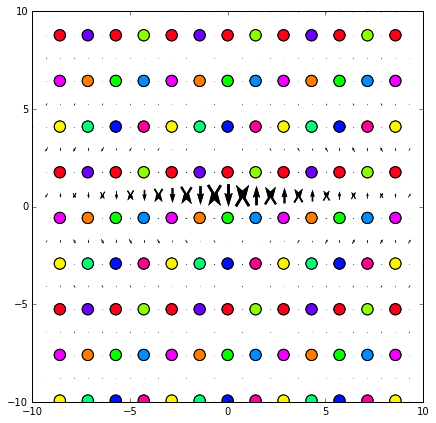

In [17]:
plot_range = np.array([[-10, 10], [-10, 10], [system.box.zlo, 0.0001]])
am.defect.differential_displacement(system, system_disl, burgers, plot_range, axes=axes, neighbor_list_cutoff=0.9*a)